# corrwith : 기준컬럼을 이용한 상관계수 분석

주제 : 서울시 따릉이 대여량 예측 💛
- id = 고유 id
- hour = 시간
- temperature = 온도
- precipitation = 비가 오지 않았으면 0, 비가 오면 1
- windspeed = 평균 풍속
- humidity = 습도
- visibility = 시정, 시계 (특정 기상 상태에 따른 가시성을 의미)
- ozone = 오존
- pm10 = 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- pm2.5 = 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count = 시간에 따른 따릉이 대여 수

# 필요한 모듈 불러오기

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as ols

In [59]:
bike_test = pd.read_csv('C:/Users/admin/Downloads/sbike/sbike/test.csv')
bike_train = pd.read_csv('C:/Users/admin/Downloads/sbike/sbike/train.csv')

# 데이터 확인

In [8]:
bike_train.info() 
# Dtype 확인했음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [80]:
bike_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


In [81]:
bike_test.isnull().sum()

id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

In [60]:
# 이름이 너무 기니까 바꾸기 
bike_train.rename( columns = {'hour_bef_temperature': 'temperature',
                             'hour_bef_precipitation':'precipitation',
                             'hour_bef_windspeed':'windspeed',
                             'hour_bef_humidity':'humidity',
                             'hour_bef_visibility':'visibility',
                             'hour_bef_ozone':'ozone',
                             'hour_bef_pm10':'pm10',
                             'hour_bef_pm2.5':'pm2.5'},inplace=True)

In [61]:
# 결측치 확인
bike_train.isnull().sum()

id                 0
hour               0
temperature        2
precipitation      2
windspeed          9
humidity           2
visibility         2
ozone             76
pm10              90
pm2.5            117
count              0
dtype: int64

In [45]:
bike_train.head(2)
# 정규화 혹은 표준화를 해줘야겠다. --> 정규분포인지 확인
# 대여수 count = 연속형 

id  hour  temperature  precipitation  windspeed  humidity  visibility  \
0   3    20         16.3            1.0        1.5      89.0       576.0   
1   6    13         20.1            0.0        1.4      48.0       916.0   

   ozone  pm10  pm2.5  count  
0  0.027  76.0   33.0   49.0  
1  0.042  73.0   40.0  159.0

In [88]:
bike_test.head(2)

id  hour  hour_bef_temperature  hour_bef_precipitation  hour_bef_windspeed  \
0   0     7                  20.7                     0.0                 1.3   
1   1    17                  30.0                     0.0                 5.4   

   hour_bef_humidity  hour_bef_visibility  hour_bef_ozone  hour_bef_pm10  \
0               62.0                954.0           0.041           44.0   
1               33.0               1590.0           0.061           49.0   

   hour_bef_pm2.5  
0            27.0  
1            36.0

# 결측치 처리
## 결측치 대체하기
- 결측치를 모두 지울것인가, 대체할 것인가?
- 결측값을 대체해주겠다 ! --> bike_train에 다시 저장해주겠다.
- 중앙값으로 대체할지, 최빈값으로 대체할지, 평균값으로 대체할지 알아보자
- 결측치 제일 많은 3개 : ozone, pm10, pm2.5 형태 확인
- 3개 다 오른쪽 꼬리를 가진 형태 -->  최빈값 > 중앙값
- 중앙값으로 처리해주겠습니다 --> 옳은 선택일까..?😭

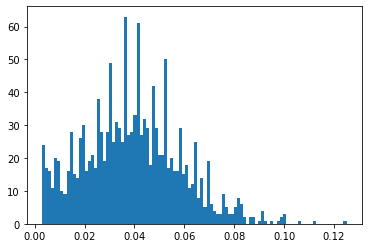

In [63]:
# 3개 다 오른쪽 꼬리를 가진 형태 -->  최빈값 > 중앙값 > 평균값
nbins = 100
plt.hist(bike_train['ozone'], bins=nbins)
plt.show()

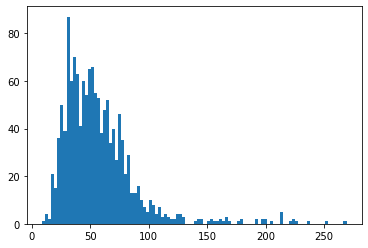

In [54]:
nbins = 100
plt.hist(bike_train['pm10'], bins=nbins)
plt.show()

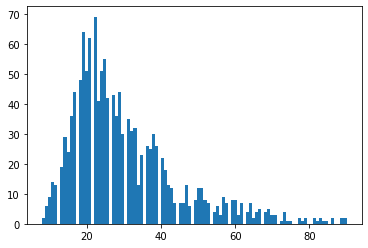

In [55]:
nbins = 100
plt.hist(bike_train['pm2.5'], bins=nbins)
plt.show()

## 결측값 대체

In [93]:
bike_train = bike_train.fillna(bike_train.median(numeric_only=True))

In [68]:
bike_train.isnull().sum() # 확인용

id               0
hour             0
temperature      0
precipitation    0
windspeed        0
humidity         0
visibility       0
ozone            0
pm10             0
pm2.5            0
count            0
dtype: int64

## bike_test는 테스트용이니까 결측치 다 지우기

In [94]:
bike_test = bike_test.dropna()

In [85]:
bike_test.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

#### test_는 일단 스케일링 빼자

In [102]:
bike_test.head(3) # 테스트는 target값이 없다. 내가 찾아내야하는 것임. 

id  hour  hour_bef_temperature  hour_bef_precipitation  hour_bef_windspeed  \
0   0     7                  20.7                     0.0                 1.3   
1   1    17                  30.0                     0.0                 5.4   
2   2    13                  19.0                     1.0                 2.1   

   hour_bef_humidity  hour_bef_visibility  hour_bef_ozone  hour_bef_pm10  \
0               62.0                954.0           0.041           44.0   
1               33.0               1590.0           0.061           49.0   
2               95.0                193.0           0.020           36.0   

   hour_bef_pm2.5  
0            27.0  
1            36.0  
2            28.0

# 스캐일을 표준화로할 것인지, 정규화로 확인할 것인지 판단 
--> 정규분포그림이 아니니까 min-max(정규화)로 해보겠습니다.

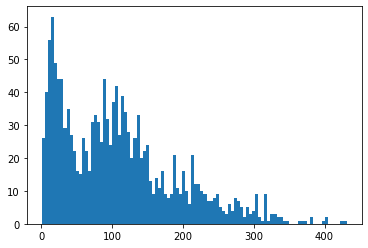

In [19]:
nbins = 100
plt.hist(bike_train['count'], bins=nbins)
plt.show()

# Min-max
- 주의 !!! : precipitation = 비가 오지 않았으면 0, 비가 오면 1 얘는 정규화 시키지마 !
- 주의 !! : id도 정규화하면 안됨

In [148]:
bike_train_x = bike_train.drop(columns = ['count','precipitation','id'])
bike_train_y = bike_train['count']

In [149]:
# bike_train
# target은 바꾸면 안됨. 
minmax_scale = MinMaxScaler()
minmax_scale.fit(bike_train_x)
bike_train_scaled = minmax_scale.transform(bike_train_x)

bike_train_scaled[:3]

array([[0.86956522, 0.49070632, 0.1875    , 0.89130435, 0.2591051 ,
        0.19672131, 0.25769231, 0.30487805],
       [0.56521739, 0.63197026, 0.175     , 0.44565217, 0.43600416,
        0.31967213, 0.24615385, 0.3902439 ],
       [0.26086957, 0.40148699, 0.0875    , 0.7826087 , 0.67845994,
        0.24590164, 0.08846154, 0.13414634]])

## 정규화했으니까 precipitation,id를 다시 붙인다.

In [153]:
bike_train_scaled = pd.DataFrame(bike_train_scaled, columns = ['hour','temperature','windspeed','humidity','visibility','ozone','pm10',
                                                              'pm2.5'])
bike_train_scaled.head(10)

hour  temperature  windspeed  humidity  visibility     ozone      pm10  \
0  0.869565     0.490706     0.1875  0.891304    0.259105  0.196721  0.257692   
1  0.565217     0.631970     0.1750  0.445652    0.436004  0.319672  0.246154   
2  0.260870     0.401487     0.0875  0.782609    0.678460  0.245902  0.088462   
3  1.000000     0.185874     0.3375  0.510870    0.451613  0.303279  0.253846   
4  0.782609     0.981413     0.6000  0.000000    1.000000  0.442623  0.069231   
5  0.086957     0.390335     0.2125  0.793478    0.517690  0.196721  0.096154   
6  0.130435     0.278810     0.1875  0.554348    0.764828  0.286885  0.203846   
7  0.913043     0.479554     0.7500  0.152174    0.979709  0.385246  0.311538   
8  0.391304     0.397770     0.2375  0.619565    0.658689  0.295082  0.323077   
9  0.608696     0.524164     0.2625  0.271739    0.776795  0.180328  0.211538   

      pm2.5  
0  0.304878  
1  0.390244  
2  0.134146  
3  0.682927  
4  0.036585  
5  0.085366  
6  0.304878  
7  0.243902  
8  0.134146  
9  0.134146

In [155]:
bike_train_new = pd.concat([bike_train_scaled,bike_train.precipitation, bike_train.id],axis=1)
bike_train_new # input값들을 이제 제대로 만든것이다.

hour  temperature  windspeed  humidity  visibility     ozone  \
0     0.869565     0.490706     0.1875  0.891304    0.259105  0.196721   
1     0.565217     0.631970     0.1750  0.445652    0.436004  0.319672   
2     0.260870     0.401487     0.0875  0.782609    0.678460  0.245902   
3     1.000000     0.185874     0.3375  0.510870    0.451613  0.303279   
4     0.782609     0.981413     0.6000  0.000000    1.000000  0.442623   
...        ...          ...        ...       ...         ...       ...   
1454  0.173913     0.509294     0.2000  0.500000    1.000000  0.229508   
1455  0.130435     0.286245     0.4750  0.413043    1.000000  0.295082   
1456  0.217391     0.565056     0.2375  0.510870    1.000000  0.049180   
1457  0.913043     0.654275     0.4625  0.326087    0.685224  0.647541   
1458  0.739130     0.669145     0.3875  0.434783    0.985952  0.352459   

          pm10     pm2.5  precipitation    id  
0     0.257692  0.304878            1.0     3  
1     0.246154  0.390244            0.0     6  
2     0.088462  0.134146            0.0     7  
3     0.253846  0.682927            0.0     8  
4     0.069231  0.036585            0.0     9  
...        ...       ...            ...   ...  
1454  0.107692  0.231707            0.0  2174  
1455  0.096154  0.134146            0.0  2175  
1456  0.080769  0.158537            0.0  2176  
1457  0.238462  0.341463            0.0  2178  
1458  0.111538  0.109756            0.0  2179  

[1459 rows x 10 columns]

# Train - test- split

In [156]:
X_train, X_test, y_train, y_test = train_test_split(bike_train_new, bike_train_y, test_size=0.2, random_state=55)

In [157]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1167, 10), (292, 10), (1167,), (292,))

# 선형 회귀  모델 구축 - OLS
- 결정계수, p-value, coef
-  선형성, 독립성, 정규성, 등분산성따라야함. 

In [161]:
train_target = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train, axis=1)
model_trained = model.fit()
model_trained.summary()
# 결정계수 : 0.856 모델 설명력 꽤 괜찮은듯?
# id는 고유값.
# visibility랑 pm2.5는 p-value높으니까 무시.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.855
Method:                 Least Squares   F-statistic:                              690.6
Date:                Fri, 04 Nov 2022   Prob (F-statistic):                        0.00
Time:                        17:37:01   Log-Likelihood:                         -6263.0
No. Observations:                1167   AIC:                                  1.255e+04
Df Residuals:                    1157   BIC:                                  1.260e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
hour            107.5747      6.021     17.865      0.000      95.760     119.389
temperature     139.9796      9.515     14.711      0.000     121.310     158.649
windspeed        40.1195     11.628      3.450      0.001      17.305      62.934
humidity        -41.8472      5.987     -6.990      0.000     -53.593     -30.101
visibility       -2.1863      5.102     -0.429      0.668     -12.196       7.823
ozone            40.1227     13.158      3.049      0.002      14.307      65.938
pm10            -83.0932     14.812     -5.610      0.000    -112.155     -54.031
pm2.5             2.1838     10.963      0.199      0.842     -19.326      23.694
precipitation   -48.3595      9.364     -5.165      0.000     -66.731     -29.988
id               -0.0018      0.002     -0.763      0.446      -0.006       0.003
==============================================================================
Omnibus:                      149.296   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.512
Skew:                           0.875   Prob(JB):                     1.97e-51
Kurtosis:                       4.319   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [163]:
model = sm.OLS(y_train, X_train.drop(['visibility', 'pm2.5'], axis = 1))
model_trained = model.fit()
print(model_trained.summary())

                                 OLS Regression Results                                
Dep. Variable:                  count   R-squared (uncentered):                   0.856
Model:                            OLS   Adj. R-squared (uncentered):              0.855
Method:                 Least Squares   F-statistic:                              864.5
Date:                Fri, 04 Nov 2022   Prob (F-statistic):                        0.00
Time:                        17:39:37   Log-Likelihood:                         -6263.1
No. Observations:                1167   AIC:                                  1.254e+04
Df Residuals:                    1159   BIC:                                  1.258e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

## 확률오차의 정규성 확인
- 그래프 확인결과 정규성을 따른다.

C:\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


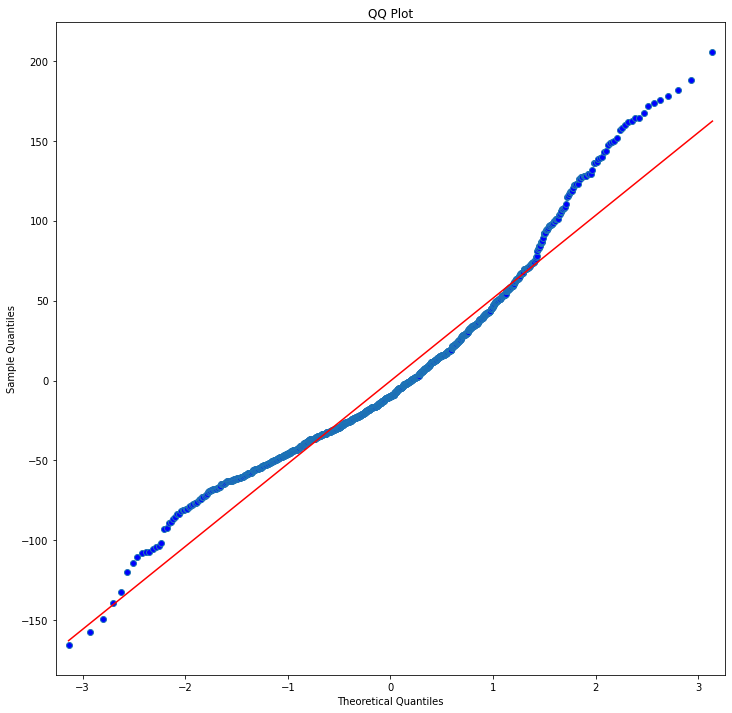

In [159]:
model_residuals = model_trained.resid

fig, ax = plt.subplots(1, 1)
fig.set_figheight(12)
fig.set_figwidth(12)
sm.ProbPlot(model_residuals).qqplot(line='s', color='#1f77b4', ax=ax)
ax.title.set_text('QQ Plot')

## 등분산성 확인
- 어느정도 따르는 듯

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Residuals vs Fitted'),
 Text(0.5, 0, 'Fitted values'),
 Text(0, 0.5, 'Residuals')]

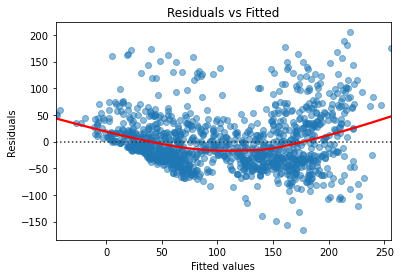

In [160]:
model_fitted_y = model_trained.fittedvalues

fig, ax = plt.subplots(1, 1)
fig.set_figheight(4)
fig.set_figwidth(6)

sns.residplot(model_fitted_y, y_train, data = X_train, lowess = True, scatter_kws = {'alpha' : 0.5}, line_kws = {'color' : 'red'}, ax = ax)
#ax.title.set_text('Residuals vs Fitted')
ax.set(title= 'Residuals vs Fitted', xlabel = 'Fitted values', ylabel = 'Residuals')

# 모든 변수값 그래프로 관계 알아보기

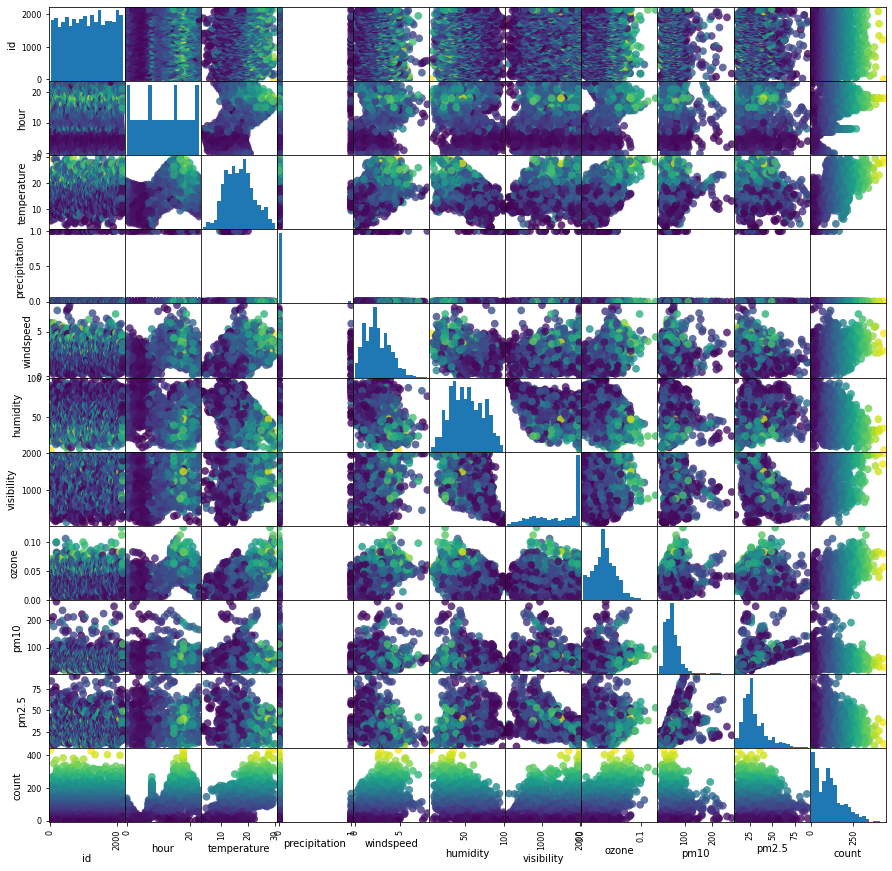

In [72]:
pd.plotting.scatter_matrix(bike_train, c=y, figsize=(15, 15), marker='o', 
                           hist_kwds = {'bins':20}, s = 60, alpha=.8) 
plt.show()
# y = bike_train['count']
# c = 색지정

# 다중회귀(Multiple Regression)